In [1]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer

# Abstract

In this blog post, I utilized my past implementation of a logistic regression model, and extended it by creating an optimizer that used Newton's Method for optimization. Newton's Method is a second-order optimization technique, and as such, is expected to converge the logistic regression model's loss to an acceptable answer in fewer iterations. To confirm my optimizer's functionality, I conducted three experiments that illustrated my model converging properly when using Newton's Method as an optimizer, Newton's Method converging in fewer iterations than standard gradient descent, and the property of Newton's Method failing to converge when the learning rate $\alpha$ is too large. I finished this blog post by analyzing the computational cost of Newton's Method and standard gradient descent and then comparing the two.

# Part A: Implement `NewtonOptimizer`

Here is a link to my [logistic.py](https://github.com/opfleet/opfleet.github.io/blob/main/posts/NewtonPost/logistic.py) file, which contains my documented implementation of the logistic regression model and `NewtonOptimizer` which I use throughout this blog post.

# Part B: Perform Experiments

Here is a code chunk to generate arbitrary data with two labels that my logistic regression model will be able to classify throughout my experiments.

In [2]:
import torch
from matplotlib import pyplot as plt

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

### Experiment 1: Choosing $\alpha$
**Hypothesis**: When $\alpha$ is chosen appropriately, Newton's Method converges to the correct choice of **w**.

Below, I generated 2-dimensional classification data with 500 data points for my logistic regression model to be trained on. I then instantiated a logistic regression model, as well as my `NewtonOptimizer`, which implements Newton's Method. I then ran a training loop for 200 iterations, and used an $\alpha$ value of 200 for my optimization steps.

In [32]:
torch.manual_seed(123)
X, y = classification_data(n_points= 500, noise= 0.5, p_dims= 2)

LR_newt = LogisticRegression()
opt_newt = NewtonOptimizer(LR_newt)

loss_vec_newt = []
for _ in range(200):
    local_loss = LR_newt.loss(X, y).item()
    opt_newt.step(X, y, alpha= 200)
    
    loss_vec_newt.append(local_loss)

print(loss_vec_newt)
w_vec = torch.clone(LR_newt.w)

[0.5663606524467468, 0.38903510570526123, 0.3066951036453247, 0.25806131958961487, 0.22755499184131622, 0.20831289887428284, 0.19647885859012604, 0.18954026699066162, 0.18572716414928436, 0.18378372490406036, 0.1828673779964447, 0.18246540427207947, 0.1822993904352188, 0.18223392963409424, 0.18220892548561096, 0.1821995973587036, 0.18219614028930664, 0.18219491839408875, 0.18219442665576935, 0.1821942776441574, 0.18219421803951263, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219417333602905, 0.18219418823719025, 0.18219418823719025, 0.18219417333602905, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.18219418823719025, 0.1821941882371902

In this visualization, I have plotted the evolution of loss of my logistic regression model using Newton's Method of optimization. As can be seen, the loss converges very quickly to a value of around 0.18. The loss converges in about 10 optimization steps.

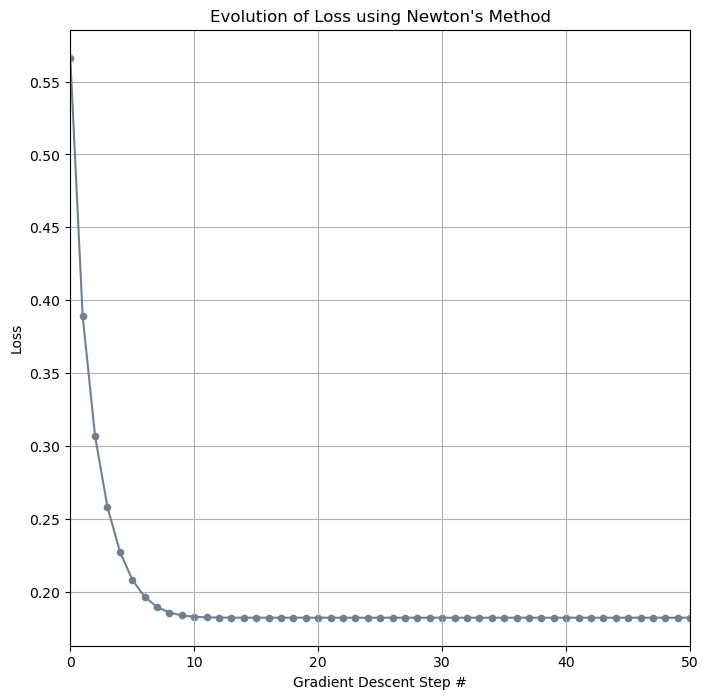

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.grid(True)
ax.plot(loss_vec_newt, color = "slategrey")
ax.scatter(torch.arange(len(loss_vec_newt)), loss_vec_newt, s = 20, color = "slategrey")
ax.set(xlim= (0, 50))
labs = ax.set(xlabel = "Gradient Descent Step #", ylabel = "Loss", title = "Evolution of Loss using Newton's Method")

Here I have defined a few functions that will assist in plotting the classification data and the decision boundary of my logistic regression model.

In [34]:
def plot_2D_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix]*2-1, facecolors = "none", edgecolors = "darkgrey", cmap = "bwr", vmin = -1, vmax = 1, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 100)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x,y,**kwargs)

As can be seen, my logistic regression model using Newton's Method of optimization has converged to a decision boundary that looks correct. While there are misclassifications, these are unavoidable due to the non-linearly separability of the data.

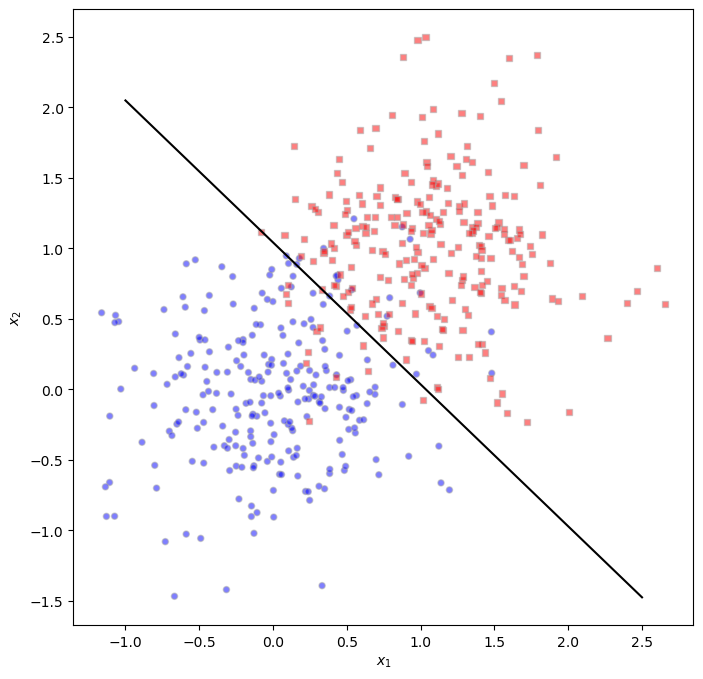

In [38]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

plot_2D_data(X, y, ax)
draw_line(w_vec, ax = ax, x_min= -1.0, x_max= 2.5, c= "black")

### Experiment 2: Speed of Convergence
**Hypothesis**: Under at least some circumstances, Newton's Method can converge much faster than standard gradient descent, in the sense of decreasing the empirical risk.

To compare the speed of Newton's Method against the speed of standard gradient descent, I instantiated and trained another logistic regression model that used standard gradient descent optimization.

In [40]:
LR_grad = LogisticRegression()
opt_grad = GradientDescentOptimizer(LR_grad)

loss_vec_grad = []
for _ in range(200):
    local_loss = LR_grad.loss(X, y).item()
    opt_grad.step(X, y, alpha= 0.1, beta= 0.1)
    
    loss_vec_grad.append(local_loss)

print(loss_vec_grad)

[0.6792325973510742, 0.6971638202667236, 0.6887470483779907, 0.6778265237808228, 0.6669315695762634, 0.6563128232955933, 0.6459912061691284, 0.6359645128250122, 0.6262282133102417, 0.6167770028114319, 0.607605516910553, 0.5987083911895752, 0.5900797843933105, 0.5817137360572815, 0.5736044645309448, 0.5657459497451782, 0.5581319332122803, 0.5507563352584839, 0.5436127781867981, 0.5366951823234558, 0.5299970507621765, 0.5235123038291931, 0.5172346830368042, 0.5111578702926636, 0.5052757859230042, 0.4995822012424469, 0.49407121539115906, 0.4887368679046631, 0.4835732579231262, 0.47857466340065, 0.47373542189598083, 0.46904993057250977, 0.4645128548145294, 0.4601188600063324, 0.45586276054382324, 0.4517396092414856, 0.4477444589138031, 0.44387251138687134, 0.4401191771030426, 0.43647998571395874, 0.4329506456851959, 0.4295268952846527, 0.426204651594162, 0.42298004031181335, 0.41984930634498596, 0.41680872440338135, 0.41385483741760254, 0.41098424792289734, 0.4081936776638031, 0.4054799377

I then plotted the evolution of the loss of both models to compare them, with the loss of the model using Newton's Method in green and the loss of the model using standard gradient descent in red. It is apparent that the loss of model using Newton's Method converges in fewer steps than the loss of the model using standard gradient descent. While it takes Newton's Method around 10 optimization steps to converge, it takes standard gradient descent at least 100 steps to converge (it seems that the loss for this model is beginning to converge around 100, although I have only plotted the loss to 100 iterations).

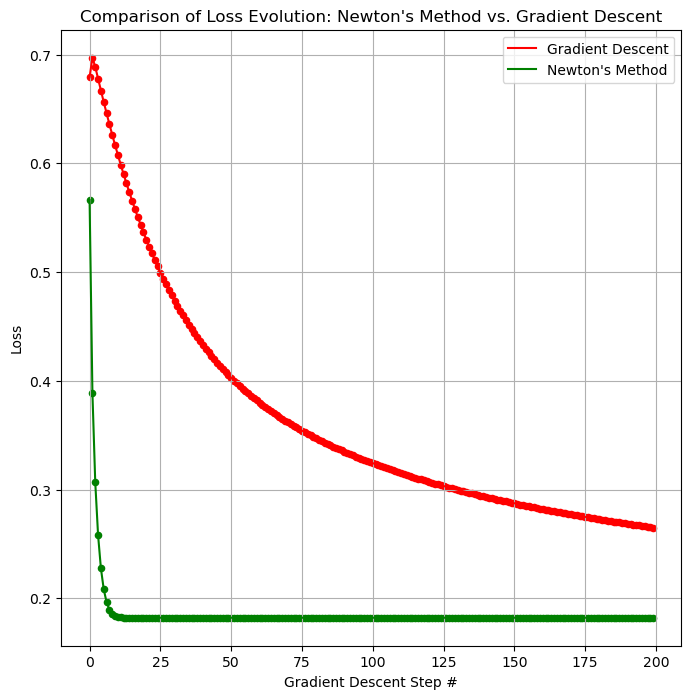

In [42]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.grid(True)
line1, = ax.plot(loss_vec_grad, color = "red", label = "Gradient Descent")
ax.scatter(torch.arange(len(loss_vec_grad)), loss_vec_grad, s = 20, color = "red")
line2, = ax.plot(loss_vec_newt, color = "green", label = "Newton's Method")
ax.scatter(torch.arange(len(loss_vec_newt)), loss_vec_newt, s = 20, color = "green")
ax.legend(handles= [line1, line2])
labs = ax.set(xlabel = "Gradient Descent Step #", ylabel = "Loss", title = "Comparison of Loss Evolution: Newton's Method vs. Gradient Descent")

### Experiment 3: Failure to Converge
**Hypothesis**: If $\alpha$ is too large, Newton's Method fails to converge.

To test this, I instantiated and trained another logistic regression model that used Newton's Method for optimization. I began training the model with an $\alpha$ value of 1000, and then steadily increased and decreased the value until the evolution of loss failed to converge. I eventually found that Newton's Method fails to converge upon this data when using an $\alpha$ value of at least 1015.

In [215]:
LR_newt = LogisticRegression()
opt_newt = NewtonOptimizer(LR_newt)

loss_vec_newt = []
for _ in range(100):
    local_loss = LR_newt.loss(X, y).item()
    opt_newt.step(X, y, alpha= 1015)
    
    loss_vec_newt.append(local_loss)

print(loss_vec_newt)

[0.4981890916824341, 0.2040444314479828, 0.1829507201910019, 0.18338710069656372, 0.18297818303108215, 0.18341781198978424, 0.18301132321357727, 0.18345630168914795, 0.1830507516860962, 0.18350304663181305, 0.18309730291366577, 0.18355880677700043, 0.1831519454717636, 0.18362431228160858, 0.1832159459590912, 0.18370071053504944, 0.18329083919525146, 0.1837894320487976, 0.18337838351726532, 0.18389193713665009, 0.18348078429698944, 0.18401022255420685, 0.18360063433647156, 0.18414635956287384, 0.18374072015285492, 0.1843028962612152, 0.18390445411205292, 0.18448254466056824, 0.18409545719623566, 0.18468840420246124, 0.1843176633119583, 0.1849239021539688, 0.1845751255750656, 0.18519286811351776, 0.1848718672990799, 0.1854993849992752, 0.18521182239055634, 0.18584798276424408, 0.1855984926223755, 0.18624359369277954, 0.1860351860523224, 0.1866917461156845, 0.1865246295928955, 0.18719840049743652, 0.1870698183774948, 0.18776987493038177, 0.18767385184764862, 0.18841281533241272, 0.1883405

I then created a visualization showing the evolution of the loss using Newton's Method. As can be seen, the loss converged until about optimization step 40, where it then began to increase steadily, thereby diverging. I highlighted this section of the evolution in red.

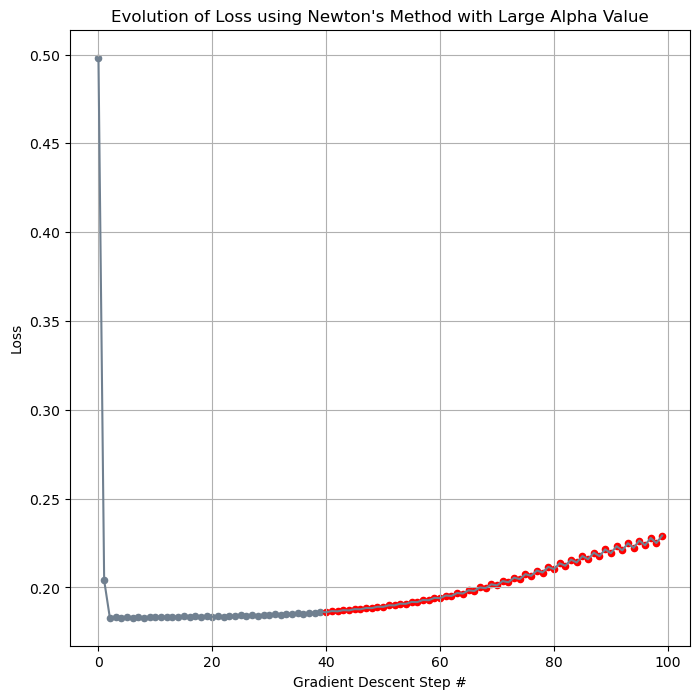

In [216]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.grid(True)
ax.plot(loss_vec_newt, color = "slategrey")
ax.scatter(torch.arange(len(loss_vec_newt)-60), loss_vec_newt[:40], s = 20, color = "slategrey")
ax.scatter(torch.arange(40, len(loss_vec_newt)), loss_vec_newt[40:], s = 20, color = "red")
labs = ax.set(xlabel = "Gradient Descent Step #", ylabel = "Loss", title = "Evolution of Loss using Newton's Method with Large Alpha Value")

# Part C: Operation Counting

Given assumptions, where $c$ is an arbitrary computational unit and $p\times p$ is the size of the Hessian matrix computed in Newton's Method:
* $O(\text{calculate } L) = c$
* $O(\text{calculate } \nabla L) = 2c$
* $O(\text{calculate } H) = pc$
* $O(\text{invert }M^{p\times p}) = k_1p^\gamma$, where $2\leq \gamma <3$
* $O(\text{multiply } v^{1\times p}M^{p\times p}) = k_2p^2$

Supposing that Newton's Method converges to a solution in $t_{nm}$ steps and standard gradient descent converges to a solution in $t_{gd}$ steps, I have written expressions below that describe the total computational cost of each optimization method.

$$
\begin{aligned}
O(\text{Gradient Descent}) &= O(L) + t_{gd}*O(\nabla L) \\
&= c + 2t_{gd}c \\
O(\text{Newton's Method}) &= O(L) + t_{nm}*\left(O(\nabla L) + O(H) + O(\text{invert } M^{p\times p}) + O(v^{1\times p}M^{p\times p})\right) \\
&= c + t_{nm}*(2c + pc + k_1p^\gamma + k_2p^2)
\end{aligned}
$$

I then put both of these expressions into an inequality to determine how much smaller $t_{nm}$ must be than $t_{gd}$ in order for Newton's Method to require fewer computations $c$ to complete. By manipulating this equality, I found that $t_{nm}$ must be smaller than $t_{gd}$ by a factor of $(1 + \frac{p}{2} + \frac{k_1p^\gamma}{2c}+\frac{k_2p^2}{2c})$, for Newton's Method to be less computational expensive than standard gradient descent. This polynomial expression is dominated by the terms $k_1p^\gamma$ and $k_2p^2$, and can be simplified as such. Therefore, when $p$ becomes very large, it is increasingly unlikely that Newton's Method will be less computationally expensive than standard gradient descent, unless it takes a logistic regression model using Newton's Method $\frac{1}{p^2}$ the number of steps to converge relative to a model using standard logistic regression.

$$
\begin{aligned}
O(\text{Gradient Descent}) &> O(\text{Newton's Method}) \\
c + 2t_{gd}c &> c + t_{nm}*(2c + pc + k_1p^\gamma + k_2p^2) \\
2t_{gd}c &> t_{nm}*(2c + pc + k_1p^\gamma + k_2p^2) \\
t_{gd} &> \frac{t_{nm}}{2c}*(2c + pc + k_1p^\gamma + k_2p^2) \\
t_{gd} &> t_{nm}*(1 + \frac{p}{2} + \frac{k_1p^\gamma}{2c} + \frac{k_2p^2}{2c})
\end{aligned}
$$

# Conclusion

In conclusion, my blog post is an extension of my previous blog post concerning logistic regression. My extension included the integration of Newton's Method as an optimizer for my logistic regression model. Newton's Method, being a second-order optimization technique, offers the potential for faster convergende, as evidenced by my experiments. In these experiments, I demonstrated the proper convergence of my optimizer, its efficiency in requiring fewer iterations compared to standard gradient descent, and the sensitivity of Newton's Method to large learning rates of $\alpha$. Furthermore, an analysis of computational costs revealed valuable insights into the trade-offs between Newton's Method and standard gradient descent; namely, how the the complexity of Newton's Method is heavily influenced by the dimensions of the data, $p$. By showcasing the advantages and limitations of both methods, this blog posts illustrates a deeper understanding of optimization techniques in logistic regression modeling.